## FaceSegLite: Model Building

### **Imports**

In [11]:
import os 

os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

--2024-01-20 16:38:47--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: ‘engine.py.1’

     0K ...                                                   100% 19.3M=0s

2024-01-20 16:38:48 (19.3 MB/s) - ‘engine.py.1’ saved [4063/4063]

--2024-01-20 16:38:48--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
S

0

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import cv2
from skimage.draw import polygon
from PIL import Image

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from torchvision.transforms import v2 as T
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

import utils

from engine import train_one_epoch, evaluate
import pycocotools

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device = {device}")

device = cpu


### **Dataset Loading**


First, we define utils function to be able to load the HuggingFace datasets correctly.

In [12]:
def load_yolo_format(file_path):
  """
  Loads a file in YOLO format and pads coordinates with zeros.

  Args:
    - file_path: path to the file to load.
  Returns:
    - objects: np array of objects in the image. Each object is represented as a
      tuple of (x1, y1, ..., xn, yn), padded with zeros if necessary.
  """
  with open(file_path, 'r') as f:
    lines = f.readlines()

  objects = []
  for line in lines:
    data = line.strip().split()
    class_index = int(data[0]) # We don't care about the class name because we work only with one class (face)
    coordinates = np.array(list(map(float, data[1:])))
    objects.append(coordinates)

  return objects

def segments_to_masks(normalized_segments, image_shape):
    """
    Convert multiple normalized segments to a labeled mask.

    Args:
        normalized_segments (list): List of normalized segments.
        image_shape (tuple): Shape of the original image.

    Returns:
        mask (torch.Tensor): Labeled mask with shape (1, h, w).
    """
    mask = np.zeros(image_shape, dtype=np.int32)

    for i, segment in enumerate(normalized_segments):
        coords = np.array(segment).reshape(-1, 2)

        # Convert normalized coordinates back to original image coordinates
        coords[:, 0] *= image_shape[1]  # width
        coords[:, 1] *= image_shape[0]  # height

        # Ensure coordinates are within the image boundaries
        coords[:, 0] = np.clip(coords[:, 0], 0, image_shape[1] - 1)
        coords[:, 1] = np.clip(coords[:, 1], 0, image_shape[0] - 1)

        # Round to integers
        coords = np.round(coords).astype(int)

        # Create a polygon and fill it in the mask
        rr, cc = polygon(coords[:, 1], coords[:, 0], shape=image_shape)
        mask[rr, cc] = i + 1

    return mask[np.newaxis, ...]

def found_directory(file_path, folders):
    """
    Finds the directory in which the file is located.

    Args:
        - file_path: path to the file to load.
        - folders: list of folders to look into.
    
    Returns:
        - folder: name of the folder in which the file is located.
    """
    for i, folder in enumerate(folders):
        file_id = file_path.split('_')[0]
        folder_id = folder.split('--')[0]
        if file_id == folder_id:
            return folders[i]
    raise ValueError(f"Folder {folders} not found in {file_path}")

Define a custom torch Dataset.

In [13]:
class FslDataset(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms

        # Get the mask files
        self.mask_folder = os.path.join(root_dir, 'masks')
        self.mask_files = sorted(os.listdir(self.mask_folder))

        # Get the image files
        self.image_folder = os.path.join(root_dir, 'images')
        self.image_files = [os.path.join(self.image_folder, found_directory(file_path, os.listdir(self.image_folder)),
                file_path.replace('txt', 'jpg')) for file_path in self.mask_files]

        print(self.image_files[0])
        print(self.mask_files[0])

        # Load the masks
        #self.mask = [load_yolo_format(os.path.join(self.mask_folder, self.mask_files[idx])) for idx in range(len(self.mask_files))]

        # Convert segments to masks
        #self.mask = [segments_to_masks(self.mask[idx], cv2.imread(self.image_files[idx]).shape[:-1]) for idx in range(len(self.mask_files))]


    def __len__(self):
        return len(self.mask_files)


    def __getitem__(self, idx):
        # Get the image
        #image = cv2.imread(self.image_files[idx])
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_np = np.array(Image.open(self.image_files[idx])) # Read image

        mask_path = os.path.join(self.mask_folder, self.mask_files[idx])

        mask_yolo = load_yolo_format(mask_path)
        mask = segments_to_masks(mask_yolo, img_np.shape[:-1])

        image = transforms.ToTensor()(img_np)
        mask = transforms.ToTensor()(mask)
        mask = torch.permute(mask, (1, 2 ,0)) # Permute to keep coherent


        # instances are encoded as different colors
        obj_ids = torch.unique(mask)

        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        labels = torch.ones((num_objs,), dtype=torch.int64)

        boxes = masks_to_boxes(masks)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(image)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

### **Fine Tune maskrcnn_resnet50 from torchvision**


In [14]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [15]:
def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

Train the model (optional)

In [17]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = FslDataset('../data/', get_transform(train=True))
dataset_test = FslDataset('../data/', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

../data/images/0--Parade/0_Parade_Parade_0_106.jpg
0_Parade_Parade_0_106.txt
../data/images/0--Parade/0_Parade_Parade_0_106.jpg
0_Parade_Parade_0_106.txt
Epoch: [0]  [  0/809]  eta: 3:42:41  lr: 0.000011  loss: 4.8457 (4.8457)  loss_classifier: 0.7429 (0.7429)  loss_box_reg: 0.1326 (0.1326)  loss_mask: 3.8368 (3.8368)  loss_objectness: 0.1203 (0.1203)  loss_rpn_box_reg: 0.0130 (0.0130)  time: 16.5166  data: 0.5533


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'trained_model.pth')
print("Model saved.")

Load a pre-trained model

In [24]:
# Load the model
loaded_model = get_model_instance_segmentation(num_classes)
loaded_model.load_state_dict(torch.load('../models/trained_model.pth', map_location=torch.device(device)))
loaded_model.to(device)
loaded_model.eval()  # Set the model to evaluation mode

print("Model loaded.")

Model loaded.


Evaluate the model

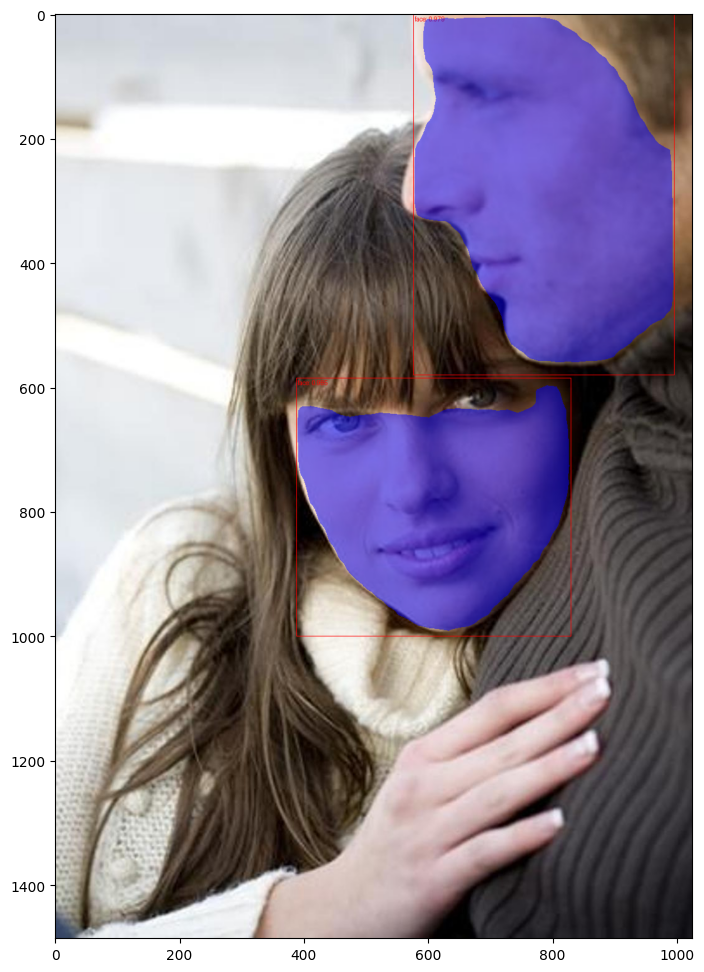

In [28]:
image = read_image("../data/images/19--Couple/19_Couple_Couple_19_167.jpg")
eval_transform = get_transform(train=False)

loaded_model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = loaded_model([x, ])
    pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

# Filter predictions with confidence score greater than 0.9
filter_mask = pred["scores"] > 0.9
pred_labels = [f"face: {score:.3f}" for score in pred["scores"][filter_mask]]
pred_boxes = pred["boxes"][filter_mask].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"][filter_mask] > 0.6).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.show()


Visualize some sample from our dataset.

In [54]:
def get_unique_color(index):
    """
    Generates a unique RGB color for a given class index.

    Args:
        - index: class index
    
    Returns:
        - color: tuple of (R, G, B) values
    """
    np.random.seed(index) # For reproducibility
    return tuple(np.random.rand(3))

def plot_image_with_segmentation_mask(image, masks, title=None):
    """
    Plots an image with its segmentation mask.

    Args:
        - image (np array): image to plot.
        - masks: list of masks in the image. Each object is represented as (x1, y1, ..., xn, yn).
    """
    # Plot the image
    plt.imshow(image)

    # Plot the segmentation mask for each object with a unique color
    for index, coordinates in enumerate(masks):
        num_points = len(coordinates) // 2
        mask_points = np.array(coordinates).reshape((num_points, 2))
        mask_points *= np.array([image.shape[1], image.shape[0]])  # Convert normalized coordinates to pixels
        mask_points = mask_points.astype(int)

        # Draw a polygon for the segmentation mask
        color = get_unique_color(index)
        polygon = Polygon(mask_points, closed=True, edgecolor=color, facecolor='none', linewidth=2)
        plt.gca().add_patch(polygon)

        # Fill the polygon with a unique color
        plt.fill(mask_points[:, 0], mask_points[:, 1], color=color, alpha=0.3)

    # Show the plot
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def show_mask(mask, ax, random_color=False):
    """
    Plots a mask. (binary mask)

    Args:
        - mask: mask to plot.
        - ax: axis to plot on.
        - random_color: if True, the mask will be plotted with a random color.
    """
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [47]:
fsl_dataset = FslDataset(root_dir='../data/')

Sample 0
Sample 0
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)
(683, 1024, 4)


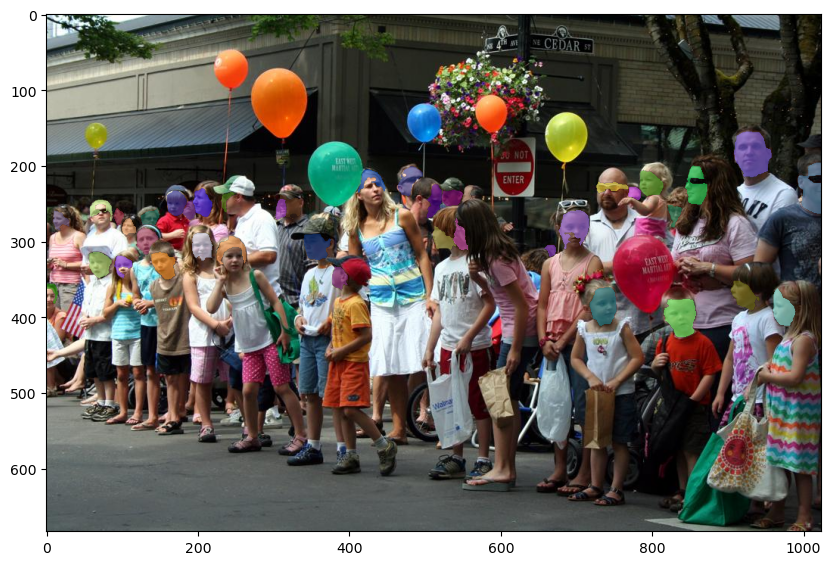

In [50]:
for i, sample in enumerate(fsl_dataset):
    if i == 1:
        break

    print(f"Sample {i}")
    plt.figure(figsize=(10,10))
    print(f"Sample {i}")
    plt.imshow(sample['image'])

    for mask in sample['masks']:
        show_mask(mask, plt.gca(), random_color=True)

### **Dataset Transformation**

TODO: Here we define the transformation for our dataset to be able to work efficiently for building our model

In [5]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, masks = sample['image'], sample['masks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        masks = np.array([transform.resize(mask, (new_h, new_w)) for mask in masks])

        return {'image': img, 'masks': masks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, masks = sample['image'], sample['masks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))


        # Pad the masks to have the same size
        # 50 is the max number of masks
        nb_of_pad = 50 - masks.shape[0]
        np.zeros((nb_of_pad, masks.shape[1], masks.shape[2]))
        padded_masks = np.concatenate((masks, np.zeros((nb_of_pad, masks.shape[1], masks.shape[2]))), axis=0)
        
        return {'image': torch.from_numpy(image),
                'masks': torch.from_numpy(padded_masks)}

In [51]:
#import torchvision.transforms as T


#transform = T.Compose([
    #ToPILImage(),
    #T.Resize((256, 256)),        # Resize to a fixed size
    #T.RandomHorizontalFlip(),    # Random horizontal flip
    #T.RandomVerticalFlip(),      # Random vertical flip
    #T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust brightness, contrast, and saturation
    #T.RandomRotation(degrees=15),  # Random rotation
    #T.ToTensor(),                # Convert to tensor
    #T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
#])

trans = transforms.Compose([Rescale((256, 256)), ToTensor()])


In [70]:

fsl_dataset = FslDataset(root_dir='../data/', transform=trans)
fsl_dataset_loader = DataLoader(fsl_dataset, batch_size=4, shuffle=True, num_workers=4)

Sample torch.Size([3, 256, 256])
Sample mask torch.Size([50, 256, 256])
Sample torch.Size([3, 256, 256])
Sample mask torch.Size([50, 256, 256])
Sample torch.Size([3, 256, 256])
Sample mask torch.Size([50, 256, 256])
Sample torch.Size([3, 256, 256])
Sample mask torch.Size([50, 256, 256])


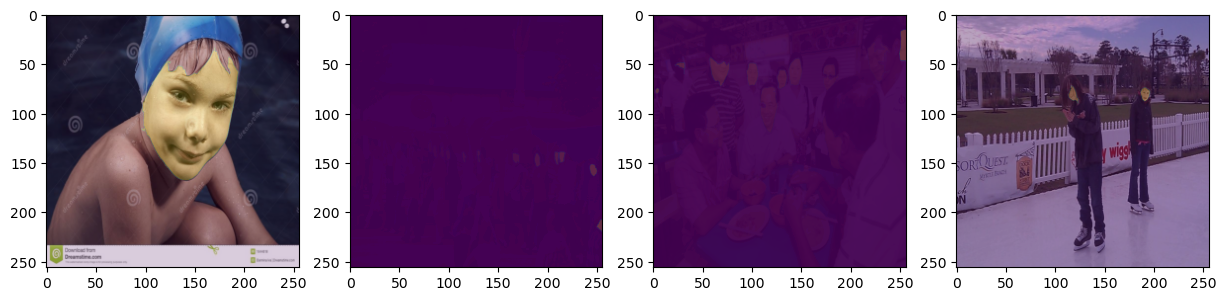

In [74]:
for batch_idx, batch in enumerate(fsl_dataset_loader):
    if batch_idx == 1:
        break

    plt.figure(figsize=(15,10))
    # Iterate through samples in the batch
    for i in range(len(batch['image'])):
        sample = {'image': batch['image'][i], 'masks': batch['masks'][i]}

        print(f"Sample {sample['image'].shape}")
        print(f"Sample mask {sample['masks'].shape}")

        plt.subplot(1, len(batch['image']), i + 1)
        plt.imshow(sample['image'].permute(1, 2, 0))

        for mask in sample['masks']:
            if mask.sum() == 0:
                continue

            # Does not work idk why
            #show_mask(mask, plt.gca(), random_color=True)

            plt.imshow(mask, alpha=0.2)

    plt.show()
